# 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',300)
import folium
import geopandas as gpd
from tqdm import tqdm
from pyproj import Proj, Transformer
tqdm.pandas()  # pandas의 tqdm 확장 활성화
import random

In [3]:
od_data = pd.read_csv("부산광역시_od.csv")
stay_data = pd.read_csv("부산광역시_stay.csv")
행정동 = gpd.read_file('emd.shp', encoding="CP949")
부산광역시_행정동 = 행정동[행정동['EMD_CD'].astype("str").str[:2] == "26"]
시군구 = gpd.read_file("sig.shp", encoding="CP949")
부산광역시_시군구 = 시군구[시군구['SIG_CD'].astype("str").str[:2] == "26"]
동리 = gpd.read_file("li.shp", encoding="CP949")
부산광역시_동리 = 동리[동리['LI_CD'].astype("str").str[:2] == "26"]

In [5]:
od_data.head(2)

,origin_hdong_cd,dest_hdong_cd,origin_hdong_cd_시도명,origin_hdong_cd_시군구명,origin_hdong_cd_읍면동명,dest_hdong_cd_시도명,dest_hdong_cd_시군구명,dest_hdong_cd_읍면동명,date,start_time,end_time,gender,age,modal,origin_purpose,dest_purpose,od_dist_avg,od_duration_avg,od_cnts,weekday,is_holiday,is_weekend
0,2614061500,2611058000,부산광역시,서구,아미동,부산광역시,중구,남포동,2023-09-01,18:00,19:00,남성,30대,차량,귀가,쇼핑여가,59052,77,9,금,평일,평일
1,2671025600,2671025300,부산광역시,기장군,정관읍,부산광역시,기장군,장안읍,2023-09-01,15:00,15:00,여성,40대,차량,업무,업무,6370,12,9,금,평일,평일


In [6]:
stay_data.head(2)

,stay,stay_시도명,stay_시군구명,stay_읍면동명,date,time,gender,age,purpose,stay_cnts,weekday,is_holiday,is_weekend
0,부산광역시 동래구 안락제2동,부산광역시,동래구,안락제2동,2023-09-01,14:00,남성,40대,귀가,803,금,평일,평일
1,부산광역시 부산진구 연지동,부산광역시,부산진구,연지동,2023-09-01,11:00,여성,50대,귀가,1175,금,평일,평일


## 전처리

#### 월, 주 뽑아내기

In [4]:
# 'date' 열을 datetime 형식으로 변환
od_data['date'] = pd.to_datetime(od_data['date'])
# 'month'와 'week_of_month' 변수를 추가
od_data['month'] = od_data['date'].dt.month
od_data['week_of_month'] = od_data['date'].apply(lambda x: (x.day - 1) // 7 + 1)
# 'month_week' 열을 추가하여 '9월 첫번째 주' 형식으로 나타냄
od_data['month_week'] = od_data.apply(lambda x: f"{x['month']}월 {x['week_of_month']}번째 주", axis=1)

# 'date' 열을 datetime 형식으로 변환
stay_data['date'] = pd.to_datetime(stay_data['date'])
# 'month'와 'week_of_month' 변수를 추가
stay_data['month'] = stay_data['date'].dt.month
stay_data['week_of_month'] = stay_data['date'].apply(lambda x: (x.day - 1) // 7 + 1)
# 'month_week' 열을 추가하여 '9월 첫번째 주' 형식으로 나타냄
stay_data['month_week'] = stay_data.apply(lambda x: f"{x['month']}월 {x['week_of_month']}번째 주", axis=1)

#### 시간대 나누기

In [5]:
od_data['end_time'] = pd.to_datetime(od_data['end_time'], format='%H:%M')
stay_data['time'] = pd.to_datetime(stay_data['time'], format='%H:%M')

# 시간대를 나누는 함수 정의
def assign_time_period(row):
    hour = row.hour
    if 6 <= hour <= 9:
        return '06:00~09:00'
    elif 10 <= hour <= 13:
        return '10:00~13:00'
    elif 14 <= hour <= 17:
        return '14:00~17:00'
    elif 18 <= hour <= 21:
        return '18:00~21:00'
    elif 22 <= hour or hour <= 1:  # 22:00~01:00
        return '22:00~01:00'
    else:  # 02:00~05:00
        return '02:00~05:00'

# 각 행에 대해 시간대를 적용
od_data['도착_시간대'] = od_data['end_time'].apply(assign_time_period)
stay_data['시간대'] = stay_data['time'].apply(assign_time_period)

#### 나이대, 목적 변수

In [6]:
def age_new(age):
    if age == "9세이하":
        return '9세이하'
    elif age == "10대":
        return '10대'
    elif age == "20대" or age == "30대":
        return '20대~30대'
    elif age == "40대" or age == "50대":
        return '40~50대'
    else:  
        return '60대이상'

od_data['나이대'] = od_data['age'].apply(age_new)
stay_data['나이대'] = stay_data['age'].apply(age_new)

In [7]:
def purpose_new(purpose):
    if purpose in ["귀가", "업무", "학업"]:
        return "일반생활"
    else:
        return "여가생활"

od_data['유입목적'] = od_data['dest_purpose'].apply(purpose_new)
stay_data['체류목적'] = stay_data['purpose'].apply(purpose_new)

In [8]:
weekend_data = od_data[od_data['is_weekend'] == '주말']
weekday_data = od_data[od_data['is_weekend'] == '평일']

# EDA

### 부산역 철도 이용 고객

In [9]:
부산역_철도_od = od_data[(od_data['modal'] == "철도")]

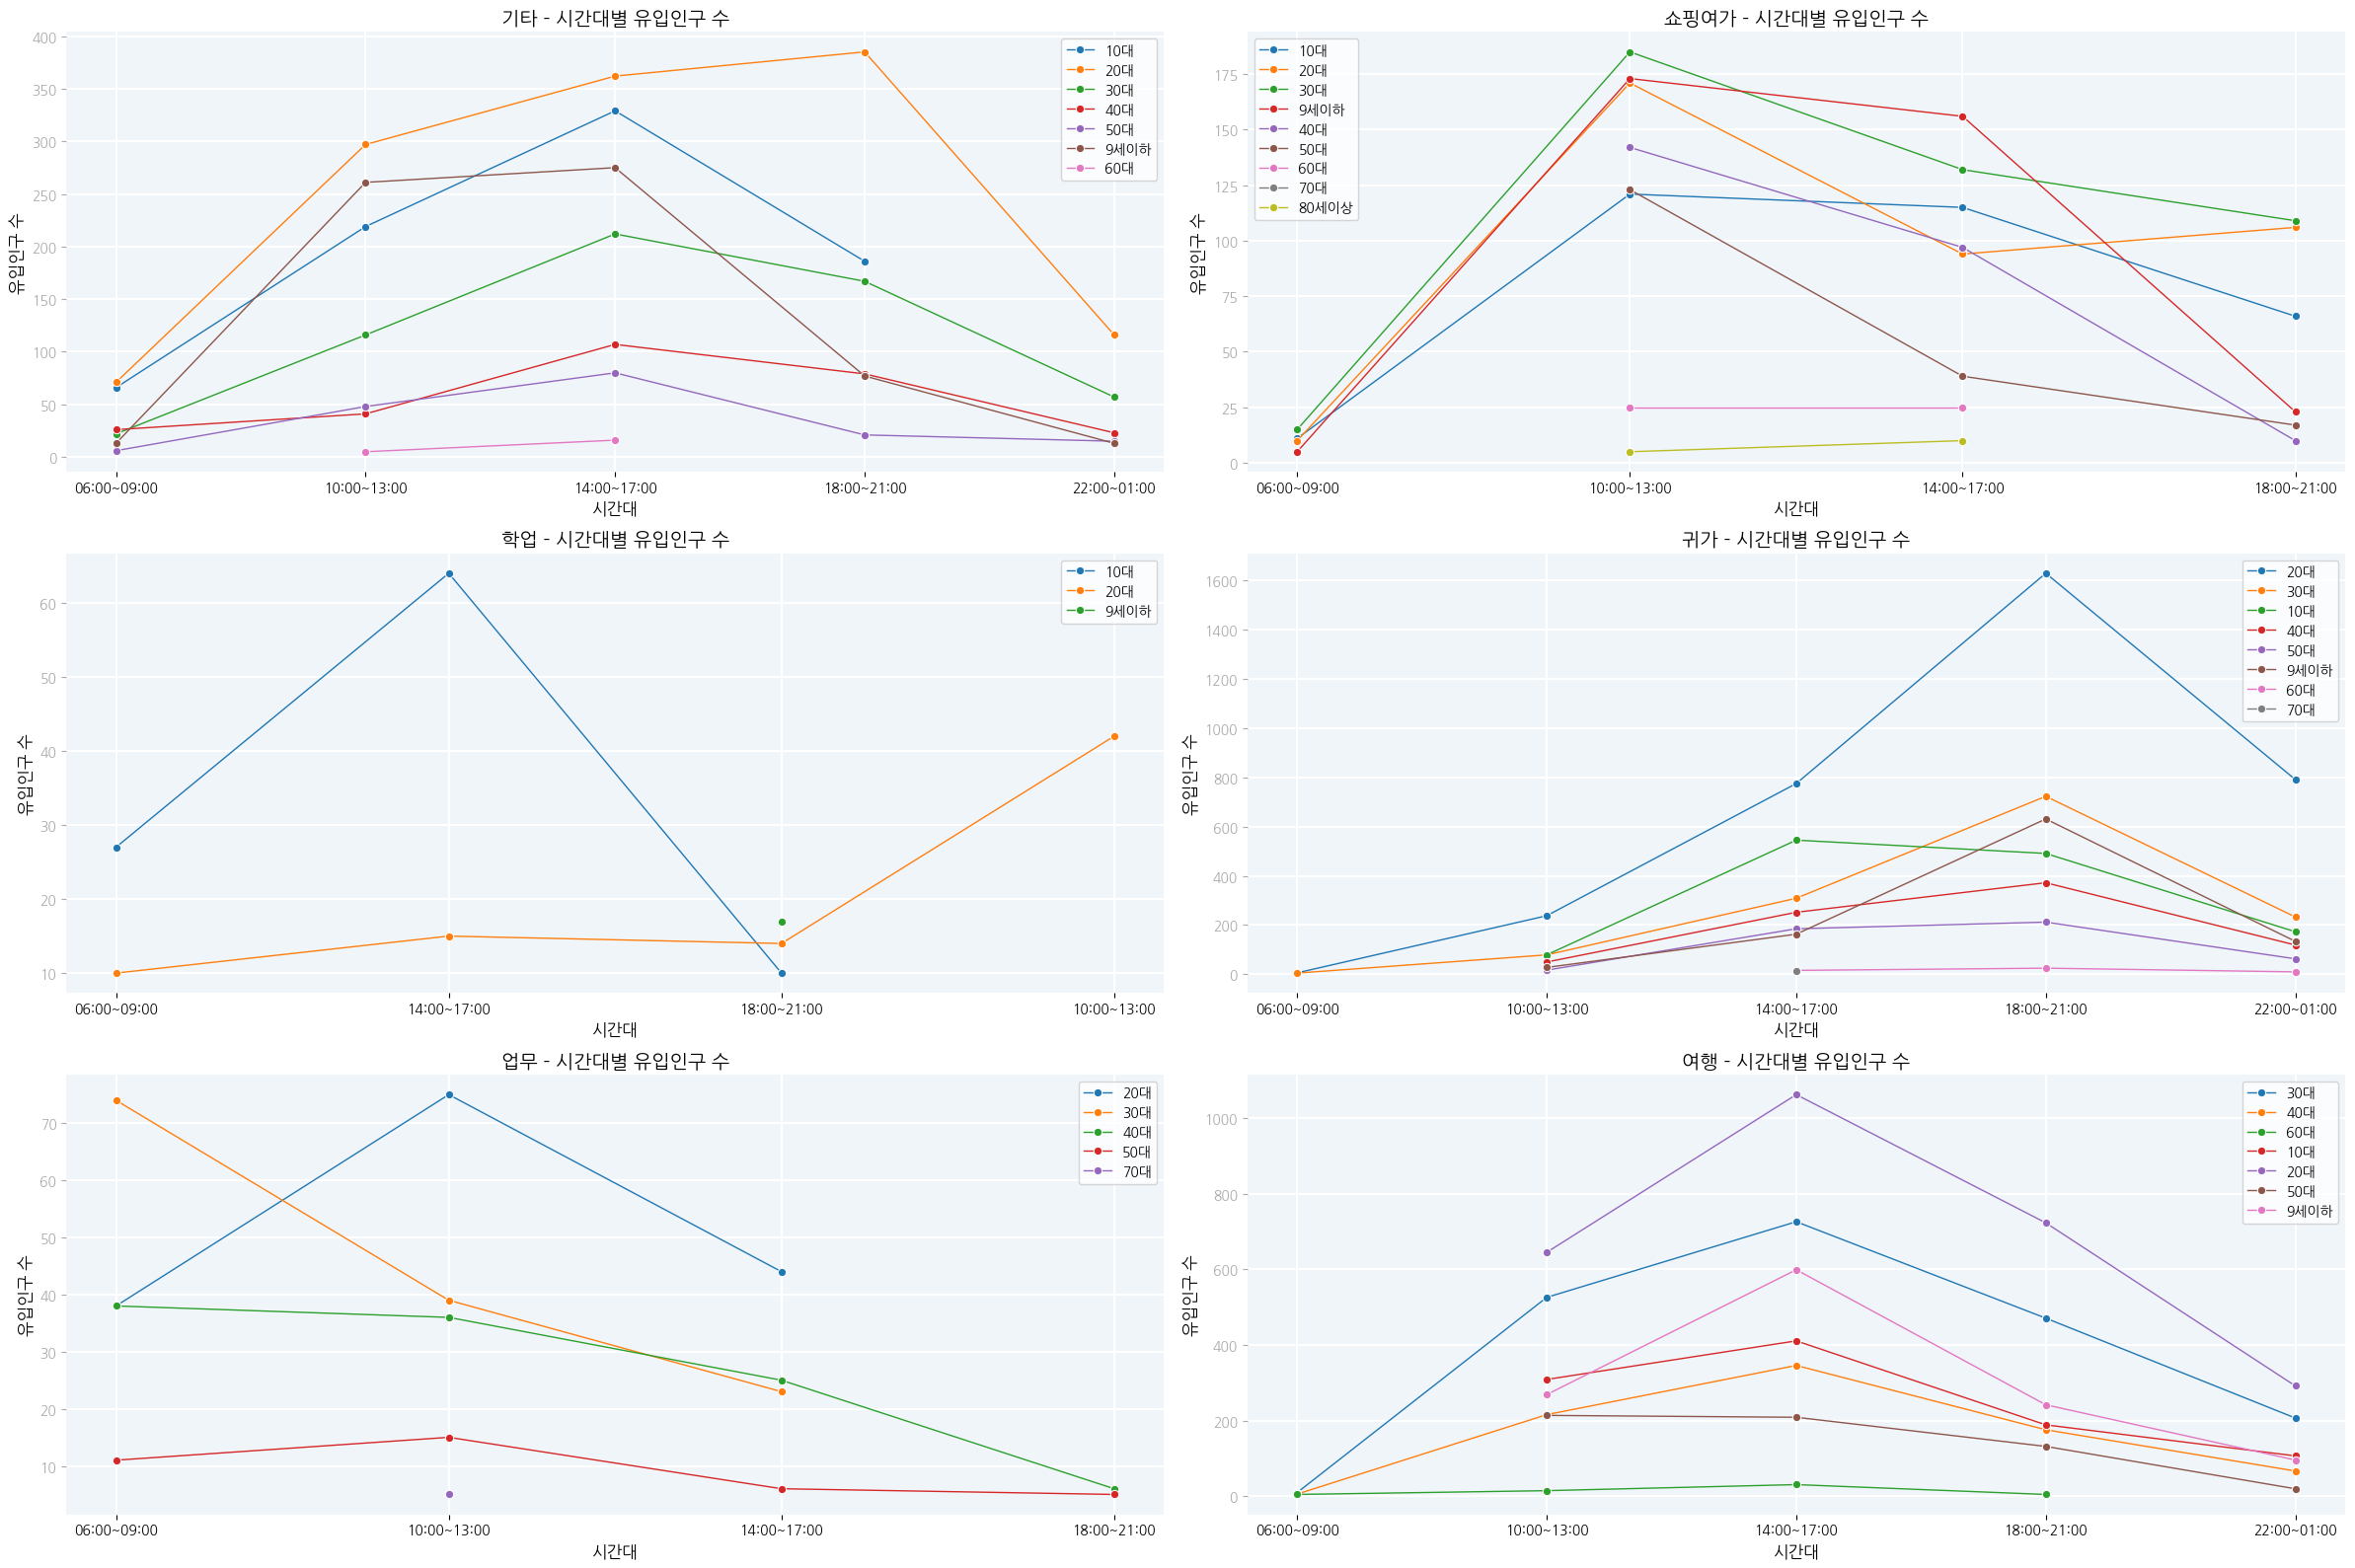

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정 (NanumGothic 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 체류인구 수 합을 시간대와 읍면동명별로 그룹화
grouped_data = 부산역_철도_od.groupby(['도착_시간대', 'age', 'dest_purpose'])['od_cnts'].sum().reset_index()

# 유입목적에 따라 플롯을 3x2로 나누기
fig, axes = plt.subplots(3, 2, figsize=(24, 16))  # 3x2 배열로 변경
axes = axes.flatten()  # 2차원 배열을 1차원으로 변환하여 인덱싱

# 플롯 배경색과 기타 설정
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('#f0f5fa')  # 플롯 배경색 설정

# 꺾은선 그래프 생성 (유입목적별로 플롯을 나눔)
for i, purpose in enumerate(grouped_data['dest_purpose'].unique()):
    ax = axes[i]
    
    # 해당 유입목적에 대한 데이터 필터링
    purpose_data = grouped_data[grouped_data['dest_purpose'] == purpose]
    
    # 읍면동명별로 꺾은선 그래프 그리기
    for 읍면동명 in purpose_data['age'].unique():
        읍면동_data = purpose_data[purpose_data['age'] == 읍면동명]
        sns.lineplot(x='도착_시간대', y='od_cnts', data=읍면동_data, ax=ax, label=읍면동명, 
                     linewidth=1, marker='o')  # 선 굵기 1로 설정, 꺾이는 부분에 점 추가
    
    # 배경에 하얀색 격자 설정
    ax.grid(True, color='white', linestyle='-', linewidth=1.5)
    
    # 그래프 제목 설정
    ax.set_title(f'{purpose} - 시간대별 유입인구 수', fontsize=14)
    
    # x축, y축 레이블 및 눈금 설정
    ax.set_xlabel('시간대', fontsize=12)
    ax.set_ylabel('유입인구 수', fontsize=12)
    
    # y축 눈금을 연하게 설정
    ax.yaxis.set_tick_params(colors='#aba9a9')

# 레이아웃 조정 및 플롯 출력
plt.tight_layout()
plt.show()


## 초량 2, 3동 연령대별 체류인구 분포

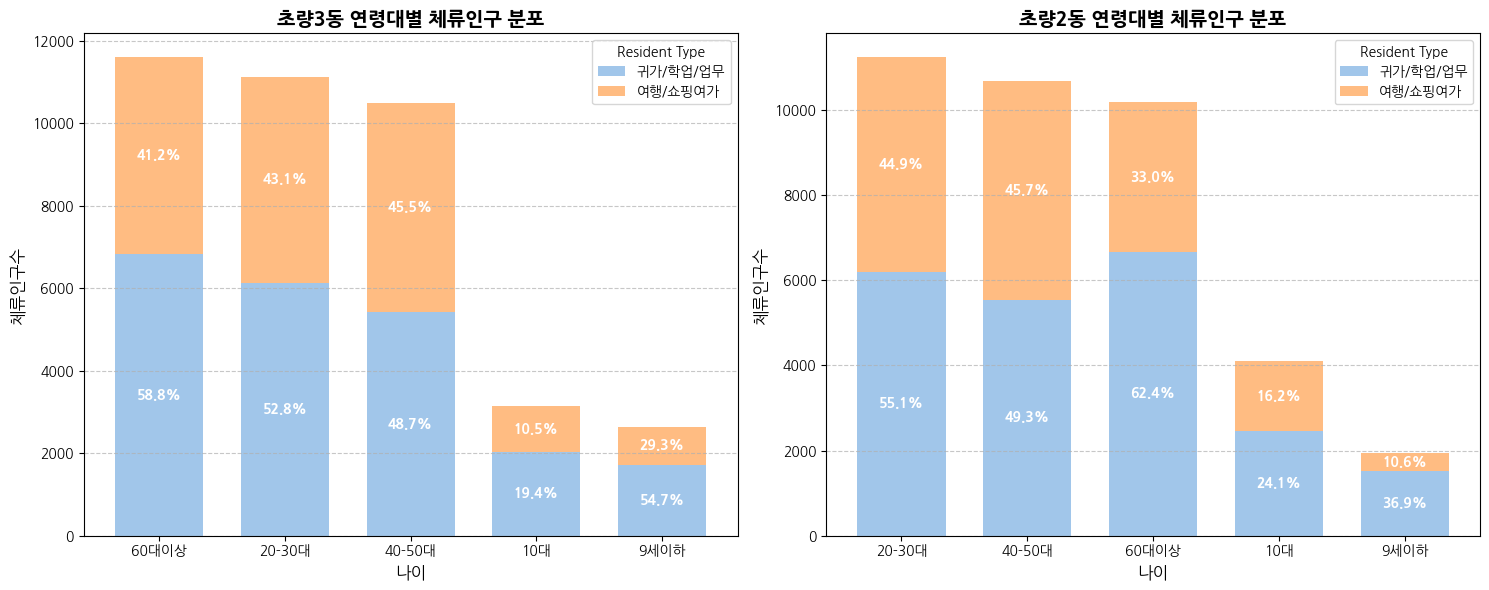

In [20]:
import matplotlib.pyplot as plt

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 초량2동, 초량3동 데이터를 시각화하는 함수
def plot_age_group_resident_type(ax, data, title, colors):
    # 데이터를 피벗 테이블 형태로 변환하여 시각화 준비
    age_group_resident_type = data[data['Resident Type'].isin(['귀가/학업/업무', '여행/쇼핑여가'])].groupby(['age_new', 'Resident Type'])['Resident Type'].count().unstack()

    # age_group을 크기 순으로 정렬
    age_group_resident_type = age_group_resident_type.loc[age_group_resident_type.sum(axis=1).sort_values(ascending=False).index]

    # 전체 합계 계산 (각 age_group별 총합)
    totals = age_group_resident_type.sum(axis=1)

    # 막대 그래프 그리기 (stacked bar chart)
    age_group_resident_type.plot(rot=0, kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

    # 막대 위에 퍼센트 표시
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        percentage = f'{(height / totals[int(x)] * 100):.1f}%'  # 비율 계산 fontweight='bold'
        ax.text(x + width / 2, y + height / 2, percentage, ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # 배경 그리드 추가
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # 그래프 제목과 라벨 설정
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('나이', fontsize=12)
    ax.set_ylabel('체류인구수', fontsize=12)

    ax.set_facecolor('white')

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 초량3동 연령대별 체류인구 분포 시각화
plot_age_group_resident_type(axes[0], 초량3동_체류인구, '초량3동 연령대별 체류인구 분포', ['#A1C6EA', '#ffbc82'])

# 초량2동 연령대별 체류인구 분포 시각화
plot_age_group_resident_type(axes[1], 초량2동_체류인구, '초량2동 연령대별 체류인구 분포', ['#A1C6EA', '#ffbc82'])

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


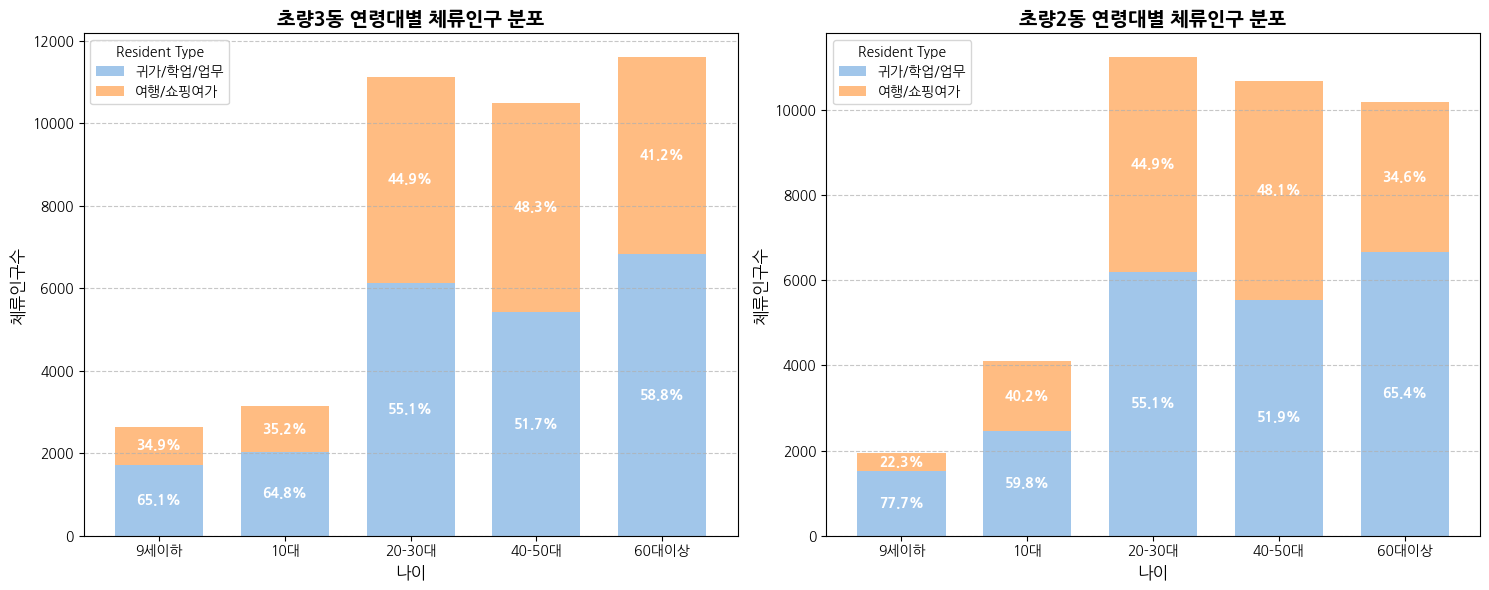

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 초량2동, 초량3동 데이터를 시각화하는 함수
def plot_age_group_resident_type(ax, data, title, colors):
    # 연령대 순서를 설정
    age_order = CategoricalDtype(['9세이하', '10대', '20-30대', '40-50대', '60대이상'], ordered=True)
    data['age_new'] = data['age_new'].astype(age_order)
    
    # 데이터를 피벗 테이블 형태로 변환하여 시각화 준비
    age_group_resident_type = data[data['Resident Type'].isin(['귀가/학업/업무', '여행/쇼핑여가'])].groupby(['age_new', 'Resident Type'])['Resident Type'].count().unstack()

    # 연령대 순서에 따라 정렬
    age_group_resident_type = age_group_resident_type.sort_index()

    # 전체 합계 계산 (각 age_group별 총합)
    totals = age_group_resident_type.sum(axis=1)

    # 막대 그래프 그리기 (stacked bar chart)
    age_group_resident_type.plot(rot=0, kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

    # 막대 위에 퍼센트 표시
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        
        # 현재 age 그룹의 총합을 찾기 위해 x 좌표와 인덱스를 매칭
        total = totals[int(x + width / 2)]
        
        # 비율 계산 후 퍼센트 표시
        percentage = f'{(height / total * 100):.1f}%' if total > 0 else ''
        ax.text(x + width / 2, y + height / 2, percentage, ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # 배경 그리드 추가
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # 그래프 제목과 라벨 설정
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('나이', fontsize=12)
    ax.set_ylabel('체류인구수', fontsize=12)

    ax.set_facecolor('white')

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 초량3동 연령대별 체류인구 분포 시각화
plot_age_group_resident_type(axes[0], 초량3동_체류인구, '초량3동 연령대별 체류인구 분포', ['#A1C6EA', '#ffbc82'])

# 초량2동 연령대별 체류인구 분포 시각화
plot_age_group_resident_type(axes[1], 초량2동_체류인구, '초량2동 연령대별 체류인구 분포', ['#A1C6EA', '#ffbc82'])

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


## 초량 2, 3동간 이동 인구 분포

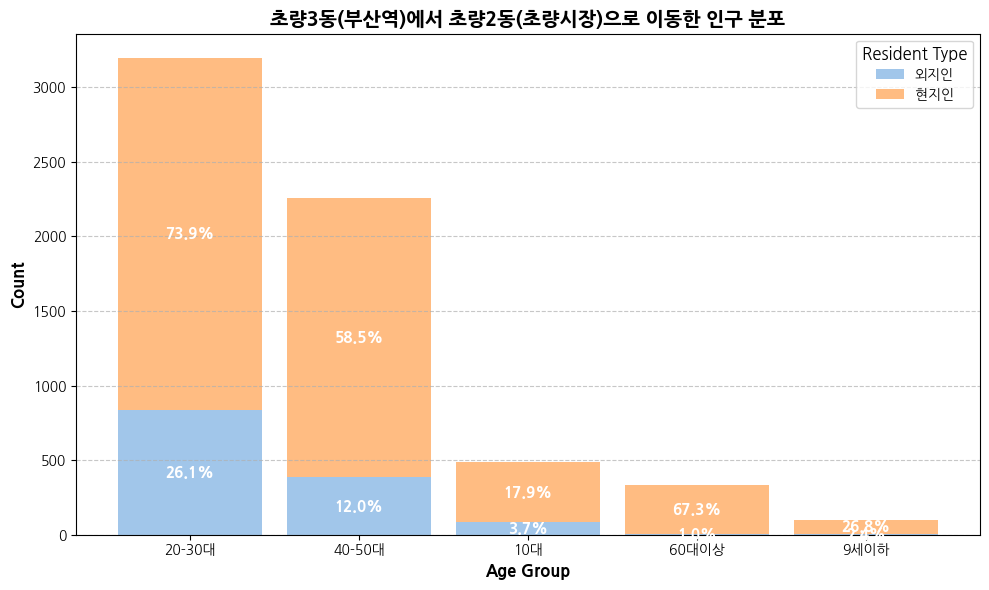

In [136]:
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터를 피벗 테이블 형태로 변환하여 시각화 준비
age_group_resident_type = 초량3_초량2_od[초량3_초량2_od['Resident Type'].isin(['현지인', '외지인'])].groupby(['age_new', 'Resident Type'])['Resident Type'].count().unstack()

# age_group을 크기 순으로 정렬
age_group_resident_type = age_group_resident_type.loc[age_group_resident_type.sum(axis=1).sort_values(ascending=False).index]

# 전체 합계 계산 (각 age_group별 총합)
totals = age_group_resident_type.sum(axis=1)

# 막대 그래프 그리기 (stacked bar chart)
fig, ax = plt.subplots(figsize=(10, 6))

# 막대 간의 간격을 줄이기 위해 'width' 옵션을 사용 
age_group_resident_type.plot(rot = 0 ,kind='bar', stacked=True, ax=ax, color=['#A1C6EA', '#ffbc82'], width=0.85)

# 막대 위에 퍼센트 표시
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    percentage = f'{(height / totals[int(x)] * 100):.1f}%'  # 비율 계산
    ax.text(x + width/2, y + height/2, percentage, ha='center', va='center', fontsize=11, color='white', fontweight='bold')

# 배경 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프 제목과 라벨 설정 (글씨체 bold 적용)
plt.title('초량3동(부산역)에서 초량2동(초량시장)으로 이동한 인구 분포', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')

# 범례 추가 (글씨체 bold 적용)
plt.legend(title='Resident Type', fontsize=10, title_fontsize=12, loc='upper right')

# 막대 간의 간격을 줄이기 위해 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()

## 연령대별 부산역 이용객 수

In [80]:
부산역_이용.groupby("age_new")[['od_cnts']].sum().sort_values(by="od_cnts", ascending=False)

,od_cnts
age_new,
20-30대,12451
40-50대,3672
10대,3518
9세이하,3175
60대이상,216


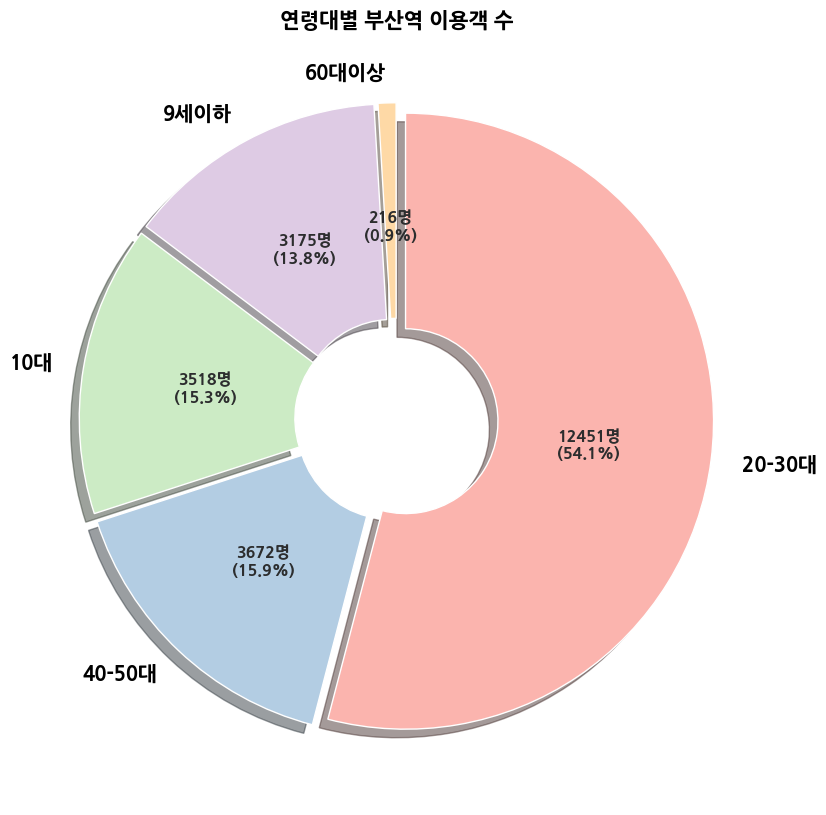

In [98]:
labels = ['20-30대', '40-50대', '10대', '9세이하', '60대이상']
ratio = [12451, 3672, 3518, 3175, 216]

cmap = plt.get_cmap("Pastel1")
colors = cmap(np.array([0, 1, 2, 3, 4]))

# 비율과 이용객 수를 함께 표시하는 함수
def func(pct, allvalues):
    absolute = int(np.round(pct/100.*np.sum(allvalues)))
    return "{:d}명\n({:.1f}%)".format(absolute, pct)

# 색상 선택
cmap = plt.get_cmap("Pastel1")
colors = cmap(np.array([0, 1, 2, 3, 4]))

plt.figure(figsize=(10, 10))  # 그래프 크기 설정

# 파이 차트 그리기
wedges, texts, autotexts = plt.pie(ratio,
                                   labels=labels,
                                   autopct=lambda pct: func(pct, ratio),  # 이용객 수와 비율을 함께 표시
                                   startangle=90,  # 축이 시작되는 각도 설정
                                   counterclock=False,  # 반시계방향으로 설정
                                   explode=[0.03]*5,  # 모든 조각을 동일한 정도로 띄움
                                   shadow=True,  # 그림자 추가
                                   colors=colors,  # 색상 설정
                                   wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}  # 조각의 너비와 테두리 설정
                                  )

# 레이블(텍스트) 크기와 굵기 설정
for text in texts:
    text.set_fontsize(14.5)  # 레이블 글씨 크기
    text.set_fontweight('bold')  # 레이블 글씨 굵기
    #text.set_color("#2c2d2e")

# 퍼센트 표시 텍스트 크기와 굵기 설정
for autotext in autotexts:
    autotext.set_fontsize(11.5)  # 퍼센트 표시 글씨 크기
    autotext.set_fontweight('bold')  # 퍼센트 표시 글씨 굵기
    autotext.set_color("#2c2d2e")

plt.title('연령대별 부산역 이용객 수', size=15, fontweight='bold')

plt.show()

## 요일별 연령대별 부산역 이용량

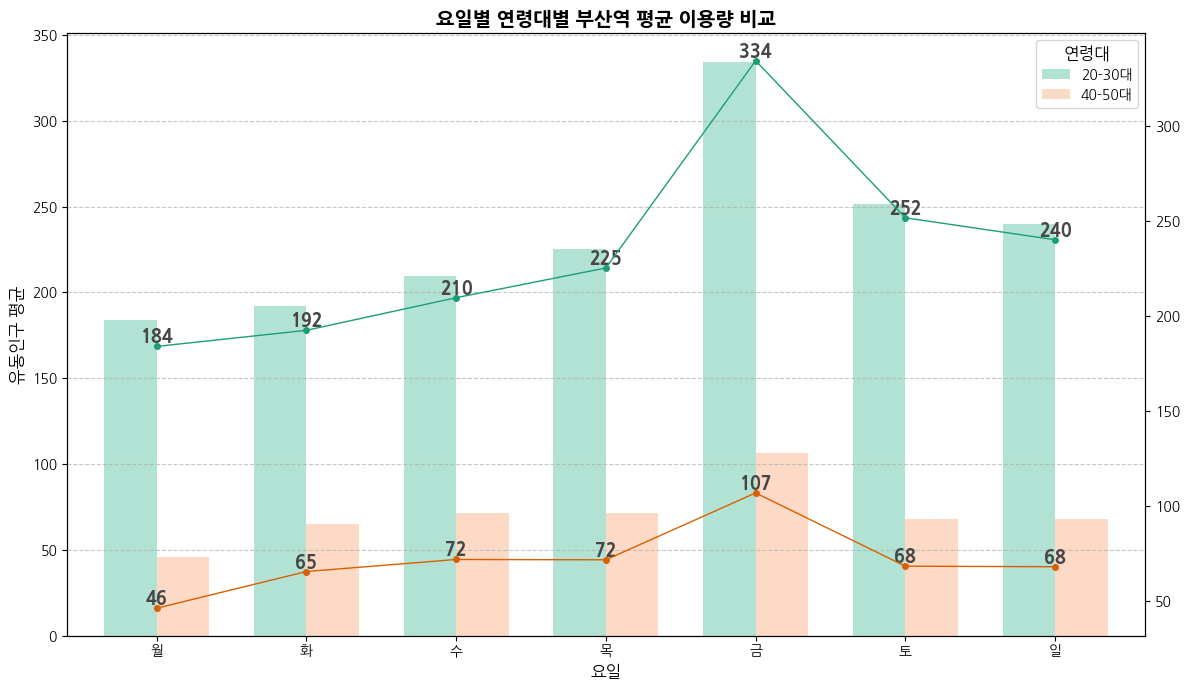

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 요일 순서 설정 (금, 토, 일, 목, 수, 화, 월 순)
weekday_order = ['월', '화', '수', '목', '금', '토', '일']

# 데이터 그룹화 및 요일별 합계 계산
grouped_data = 부산역_이용[(부산역_이용['age_new'].isin(['20-30대', '40-50대'])) & (부산역_이용['Resident Type'].isin(['귀가/학업/업무', '여행/쇼핑여가']))]\
    .groupby(['weekday', 'age_new'])[['od_cnts']].sum().unstack(['age_new'])

# 요일 순서에 맞게 인덱스를 재정렬
grouped_data = grouped_data.reindex(weekday_order)

# 요일별 합계를 계산한 후, 특정 요일에 대해 나누기 적용
for day in weekday_order:
    if day in ['월', '화', '수', '목']:  # 월~목은 6으로 나누기
        grouped_data.loc[day] = grouped_data.loc[day] / 6
    elif day in ['금', '토', '일']:  # 금, 토는 7로 나누기
        grouped_data.loc[day] = grouped_data.loc[day] / 7

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(12, 7))

# 색상 설정 (민트색은 진한 민트, 살구색은 오렌지색으로)
bar_colors = ['#B2E2D3', '#FDDAC5']
line_colors = ['#1B9E77', '#D95F02']

# 막대 그래프 그리기
grouped_data.plot(kind='bar', ax=ax, color=bar_colors, width=0.7)

# 막대의 x 좌표 설정 (막대가 가운데에 오도록)
x = np.arange(len(grouped_data))

# 꺾은선 그래프 그리기 (막대 그래프 위에)
ax2 = ax.twinx()  # y축을 공유하는 새로운 축 생성

# x좌표를 막대의 중앙에 맞춰 꺾은선 그래프 그리기
for i, age_group in enumerate(grouped_data.columns):
    ax2.plot(x, grouped_data[age_group], color=line_colors[i], linewidth=1, marker='o', markersize=4, label=f'{age_group}', zorder=5)

# 꺾은선 그래프의 각 포인트마다 od_cnts 값을 표시
for i, line in enumerate(ax2.get_lines()):
    for x_pos, y in zip(line.get_xdata(), line.get_ydata()):
        ax2.text(x_pos, y, f'{y:.0f}', ha='center', va='bottom', fontsize=13, color='#474646', fontweight='bold')

# 제목 및 축 레이블 설정
ax.set_title('요일별 연령대별 부산역 평균 이용량 비교', fontsize=14, fontweight='bold')
ax.set_xlabel('요일', fontsize=12)
ax.set_ylabel('유동인구 평균', fontsize=12)

# 범례 추가
ax.legend(labels=['20-30대', '40-50대'], title='연령대', fontsize=10, title_fontsize=12, loc='upper right')

# 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# x축 눈금 똑바로 정렬 (45도 회전 없이)
ax.tick_params(axis='x', rotation=0)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


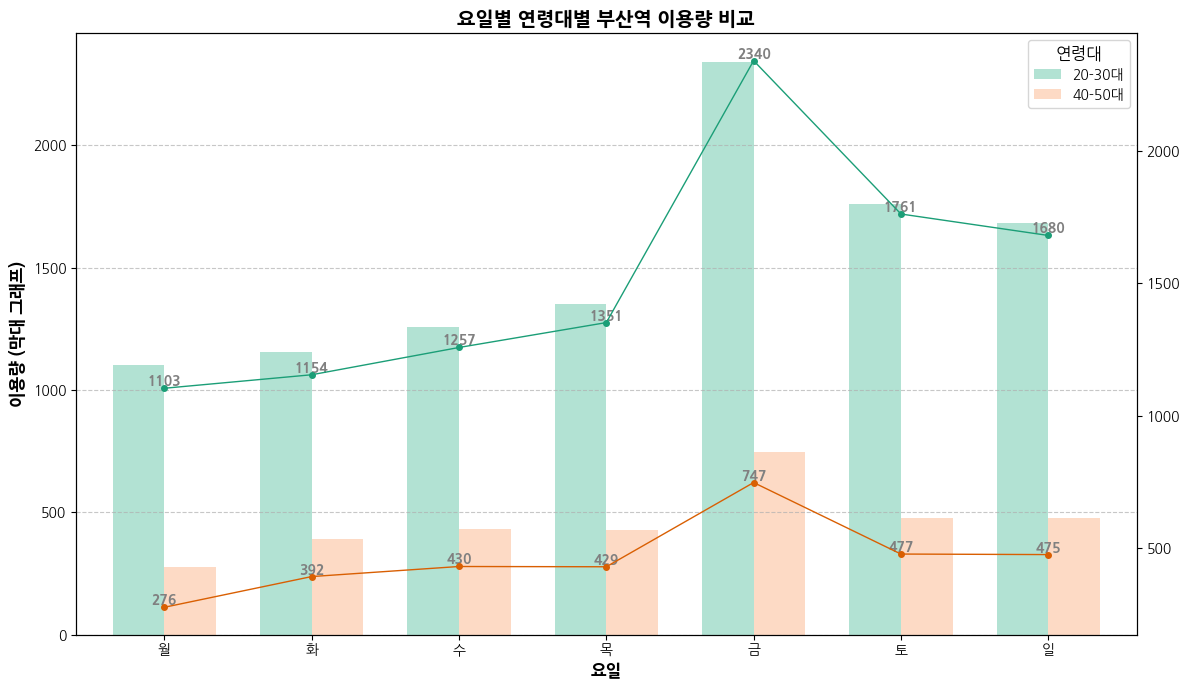

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 요일 순서 설정 (금, 토, 일, 목, 수, 화, 월 순)
weekday_order = ['월', '화', '수', '목', '금', '토', '일']
#weekday_order = ['금', '토', '일', '목', '수', '화', '월']

# 데이터 그룹화
grouped_data = 부산역_이용[(부산역_이용['age_new'].isin(['20-30대', '40-50대'])) & (부산역_이용['Resident Type'].isin(['현지인', '외지인']))]\
    .groupby(['weekday', 'age_new'])[['od_cnts']].sum().unstack(['age_new'])

# 요일 순서에 맞게 인덱스를 재정렬
grouped_data = grouped_data.reindex(weekday_order)

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(12, 7))

# 색상 설정 (민트색은 진한 민트, 살구색은 오렌지색으로)
bar_colors = ['#B2E2D3', '#FDDAC5']
line_colors = ['#1B9E77', '#D95F02']

# 막대 그래프 그리기
grouped_data.plot(kind='bar', ax=ax, color=bar_colors, width=0.7)

# 막대의 x 좌표 설정 (막대가 가운데에 오도록)
x = np.arange(len(grouped_data))

# 꺾은선 그래프 그리기 (막대 그래프 위에)
ax2 = ax.twinx()  # y축을 공유하는 새로운 축 생성

# x좌표를 막대의 중앙에 맞춰 꺾은선 그래프 그리기
for i, age_group in enumerate(grouped_data.columns):
    ax2.plot(x, grouped_data[age_group], color=line_colors[i], linewidth=1, marker='o', markersize=4, label=f'{age_group}', zorder=5)

# 꺾은선 그래프의 각 포인트마다 od_cnts 값을 표시
for i, line in enumerate(ax2.get_lines()):
    for x_pos, y in zip(line.get_xdata(), line.get_ydata()):
        ax2.text(x_pos, y, f'{y:.0f}', ha='center', va='bottom', fontsize=10, color='gray', fontweight='bold')

# 제목 및 축 레이블 설정
ax.set_title('요일별 연령대별 부산역 이용량 비교', fontsize=14, fontweight='bold')
ax.set_xlabel('요일', fontsize=12, fontweight='bold')
ax.set_ylabel('이용량 (막대 그래프)', fontsize=12, fontweight='bold')

# 범례 추가
ax.legend(labels=['20-30대', '40-50대'], title='연령대', fontsize=10, title_fontsize=12, loc='upper right')

# 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# x축 눈금 똑바로 정렬 (45도 회전 없이)
ax.tick_params(axis='x', rotation=0)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()


## 20-30대, 40-50대 부산역 도착시간

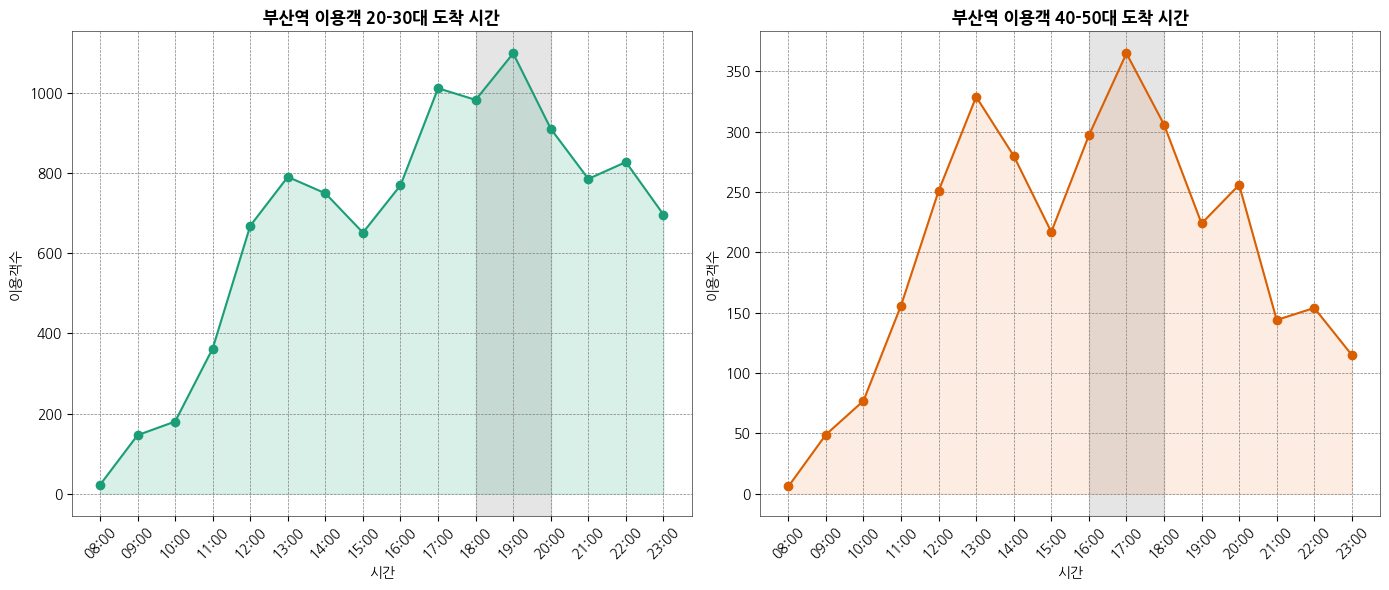

In [80]:
plt.rcParams['font.family'] = 'NanumGothic'


# 1. 금요일 데이터 필터링
#friday_data = 부산역_이용[부산역_이용['광고일'] == '평일']
#friday_data = 부산역_이용[부산역_이용['weekday'].isin(["금"])]
friday_data = 부산역_이용
#friday_data = friday_data[friday_data['Resident Type'].isin(['현지인', '외지인'])]
friday_data = friday_data[friday_data['Resident Type'].isin(['여행/쇼핑여가', '귀가/학업/업무'])]


# 2. 20~30대와 가족단위(9세 이하 및 40대)로 데이터 나누기
age_20_30 = friday_data[(friday_data['age_new'] == "20-30대")]
age_40_50 = friday_data[(friday_data['age_new'] == "40-50대")]

# 3. 외지인과 현지인 나누기
#foreigners_20_30 = age_20_30[age_20_30['people'] == '외지인']
#locals_20_30 = age_20_30[age_20_30['people'] == '현지인']

#foreigners_40_50 = age_40_50[age_40_50['people'] == '외지인']
#locals_40_50 = age_40_50[age_40_50['people'] == '현지인']

# 4. 시간대별 OD 수 합계 계산
age_20_30_sum = age_20_30.groupby('end_time')['od_cnts'].sum()
age_40_50_sum = age_40_50.groupby('end_time')['od_cnts'].sum()

# 5. 그래프 그리기 (외지인과 현지인별 1x2 그래프)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for ax in axs:
    ax.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5)

# 축선(spines)을 연한 회색으로 설정하고 굵기 조정
for ax in axs:
    #ax.spines['top'].set_color('gray')     # 연한 회색
    #ax.spines['right'].set_color('gray')   # 연한 회색
    #ax.spines['left'].set_color('gray')    # 연한 회색
    #ax.spines['bottom'].set_color('gray')  # 연한 회색

    # 축선의 굵기를 얇게 설정 (선택 사항, 기본값보다 얇게 설정)
    ax.spines['top'].set_linewidth(0.4)
    ax.spines['right'].set_linewidth(0.4)
    ax.spines['left'].set_linewidth(0.4)
    ax.spines['bottom'].set_linewidth(0.4)


# 외지인 20~30대
axs[0].plot(age_20_30_sum.index, age_20_30_sum.values, marker='o', color='#1B9E77')
axs[0].fill_between(age_20_30_sum.index, age_20_30_sum.values, color='#B2E2D3', alpha=0.5)
axs[0].set_title('부산역 이용객 20-30대 도착 시간', fontweight = "bold")
axs[0].set_xlabel('시간')
axs[0].set_ylabel('이용객수')
axs[0].tick_params(axis='x', rotation=45)


# 외지인 가족단위
axs[1].plot(age_40_50_sum.index, age_40_50_sum.values, marker='o', color='#D95F02')
axs[1].fill_between(age_40_50_sum.index, age_40_50_sum.values, color='#FDDAC5', alpha=0.5)
axs[1].set_title('부산역 이용객 40-50대 도착 시간', fontweight = "bold")
axs[1].set_xlabel('시간')
axs[1].set_ylabel('이용객수')
axs[1].tick_params(axis='x', rotation=45)


# 최대값 꼭짓점의 x축을 기준으로 약간의 범위를 지정해 회색 배경 추가
max_index_20_30 = age_20_30_sum.idxmax()
axs[0].axvspan('18:00', '20:00', color='gray', alpha=0.2)  # 꼭짓점 전후 범위를 지정하여 회색 강조

# 외지인 가족단위에서 최대값 꼭짓점 부분 강조
max_index_family = age_40_50_sum.idxmax()
axs[1].axvspan('16:00', '18:00', color='gray', alpha=0.2)  # 꼭짓점 전후 범위를 지정하여 회색 강조


plt.tight_layout()
plt.show()

## 시군구별 인구 분포

In [11]:
시군구_grouped_data_평일 = weekday_data.groupby(["유입목적", "dest_hdong_cd_시군구명"])[['od_cnts']].sum().sort_values(by=["유입목적", "od_cnts"], ascending=[True, False])
시군구_grouped_data_주말 = weekend_data.groupby(["유입목적", "dest_hdong_cd_시군구명"])[['od_cnts']].sum().sort_values(by=["유입목적", "od_cnts"], ascending=[True, False])
시군구_grouped_data_평일_reset = 시군구_grouped_data_평일.reset_index()
시군구_grouped_data_주말_reset = 시군구_grouped_data_주말.reset_index()

#### (시군구) 평일/주말 여가/일반 유입인구

In [12]:
# 평일 여가생활 데이터 병합 및 'od_cnts' 이름 변경
부산광역시_시군구 = 부산광역시_시군구.merge(
    시군구_grouped_data_평일_reset[시군구_grouped_data_평일_reset['유입목적'] == "여가생활"][['dest_hdong_cd_시군구명', 'od_cnts']],
    how="left", 
    left_on="SIG_KOR_NM", 
    right_on="dest_hdong_cd_시군구명"
)
# 'dest_hdong_cd_시군구명' 열 삭제 및 'od_cnts' 열 이름 변경
부산광역시_시군구 = 부산광역시_시군구.drop(columns=["dest_hdong_cd_시군구명"]).rename(columns={"od_cnts": "평일_여가생활_odcnts"})

# 주말 여가생활 데이터 병합 및 'od_cnts' 이름 변경
부산광역시_시군구 = 부산광역시_시군구.merge(
    시군구_grouped_data_주말_reset[시군구_grouped_data_주말_reset['유입목적'] == "여가생활"][['dest_hdong_cd_시군구명', 'od_cnts']],
    how="left", 
    left_on="SIG_KOR_NM", 
    right_on="dest_hdong_cd_시군구명"
)
# 'dest_hdong_cd_시군구명' 열 삭제 및 'od_cnts' 열 이름 변경
부산광역시_시군구 = 부산광역시_시군구.drop(columns=["dest_hdong_cd_시군구명"]).rename(columns={"od_cnts": "주말_여가생활_odcnts"})

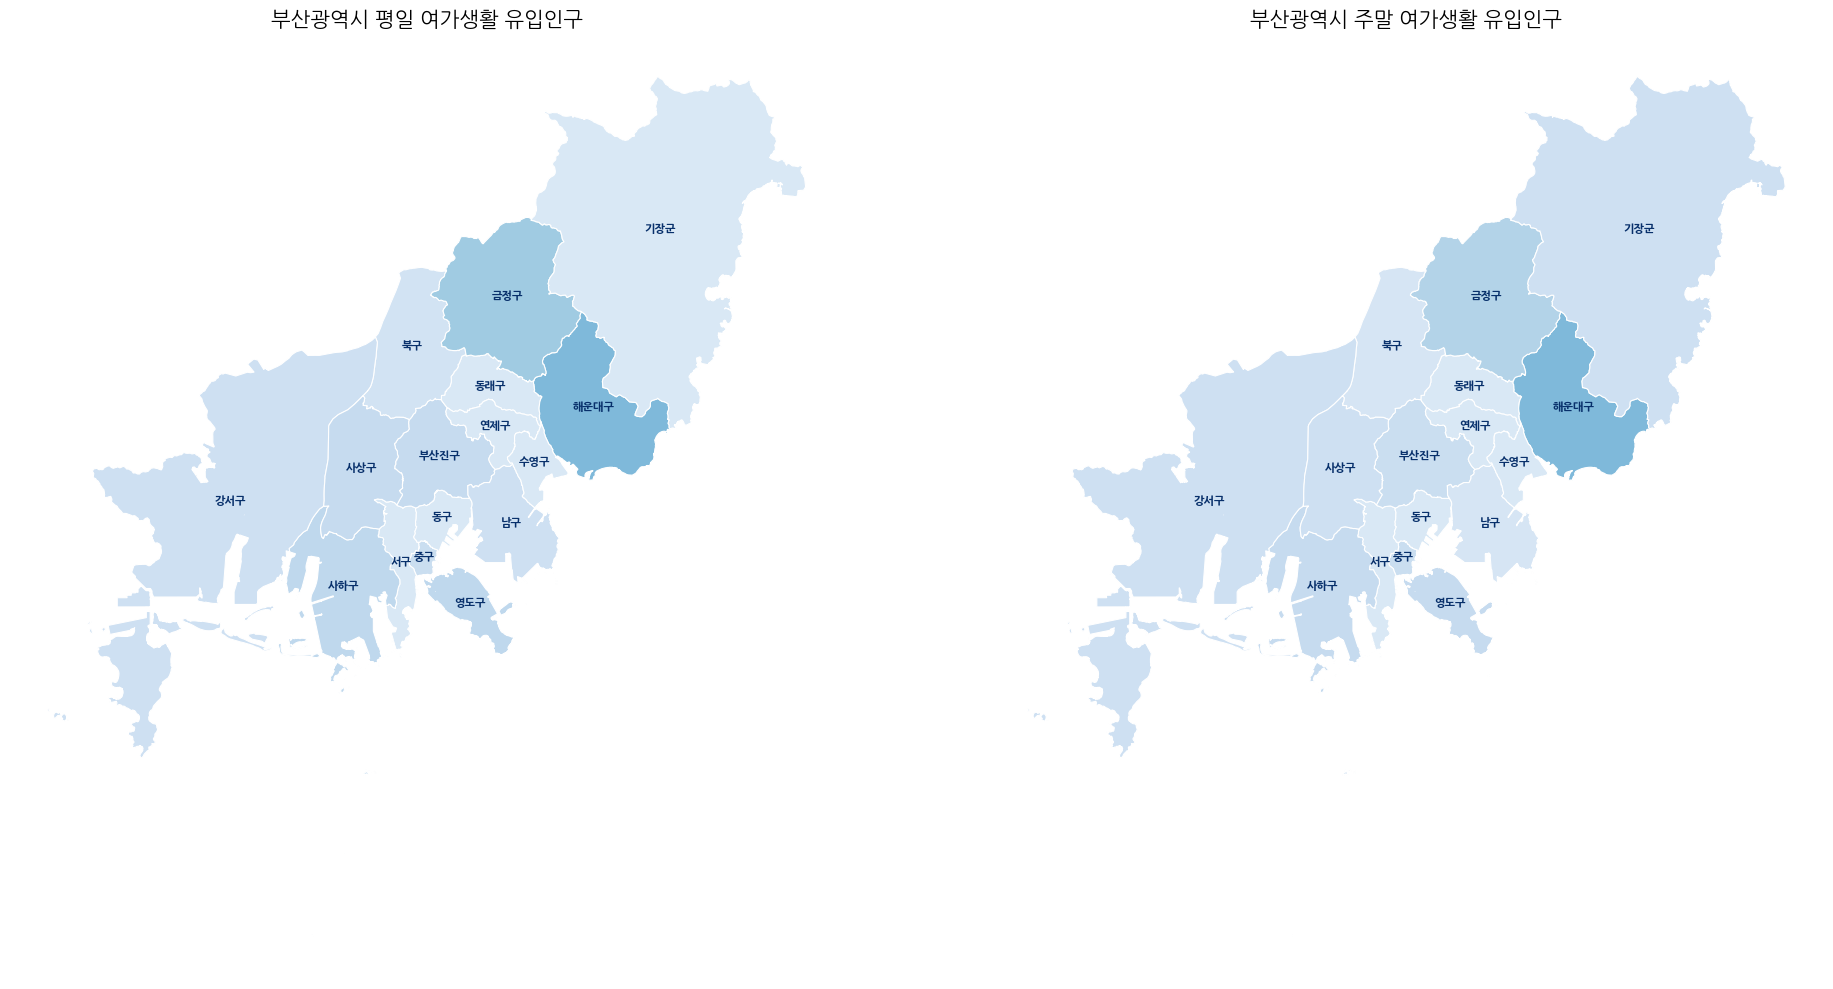

In [43]:
from matplotlib.colors import ListedColormap

# GeoDataFrame 준비 (예시로 '부산광역시_시군구'가 GeoDataFrame 형태라고 가정)
gdf = 부산광역시_시군구  # 이미 geometry 컬럼이 있는 GeoDataFrame

# 좌표계가 없는 경우 좌표계 설정 (EPSG:5179: GRS80 UTM-K)
if gdf.crs is None:
    gdf.set_crs(epsg=5179, inplace=True)

# 좌표계를 WGS84 (EPSG:4326)로 변환
gdf = gdf.to_crs(epsg=4326)

# 시군구 갯수에 맞춘 컬러맵 설정 (파란색~하늘색 계열)
num_colors = len(gdf)  # 시군구 개수
cmap = ListedColormap(plt.cm.Blues(np.linspace(0.15, 0.45, num_colors)))  # 0.3 ~ 1 사이의 파란색 ~ 하늘색

# 1x2 플롯 생성 (평일과 주말 데이터를 각각 시각화)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 1. 평일 여가생활 인구 데이터
gdf.plot(column='평일_여가생활_odcnts', cmap=cmap, linewidth=0.8, ax=axes[0], edgecolor='white')
axes[0].set_title('부산광역시 평일 여가생활 유입인구', fontsize=15)
axes[0].set_axis_off()

# 시군구명 표시 (평일 데이터)
for idx, row in gdf.iterrows():
    axes[0].text(row.geometry.centroid.x, row.geometry.centroid.y, row['SIG_KOR_NM'], 
                 fontsize=8, ha='center', color='#08306b', weight='bold')

# 2. 주말 여가생활 인구 데이터
gdf.plot(column='주말_여가생활_odcnts', cmap=cmap, linewidth=0.8, ax=axes[1], edgecolor='white')
axes[1].set_title('부산광역시 주말 여가생활 유입인구', fontsize=15)
axes[1].set_axis_off()

# 시군구명 표시 (주말 데이터)
for idx, row in gdf.iterrows():
    axes[1].text(row.geometry.centroid.x, row.geometry.centroid.y, row['SIG_KOR_NM'], 
                 fontsize=8, ha='center', color='#08306b', weight='bold')

# 범례 제거 (각각의 subplot에서 legend를 표시하지 않음)
plt.tight_layout()

# 시각화 출력
plt.show()


### 시장 위치 표시

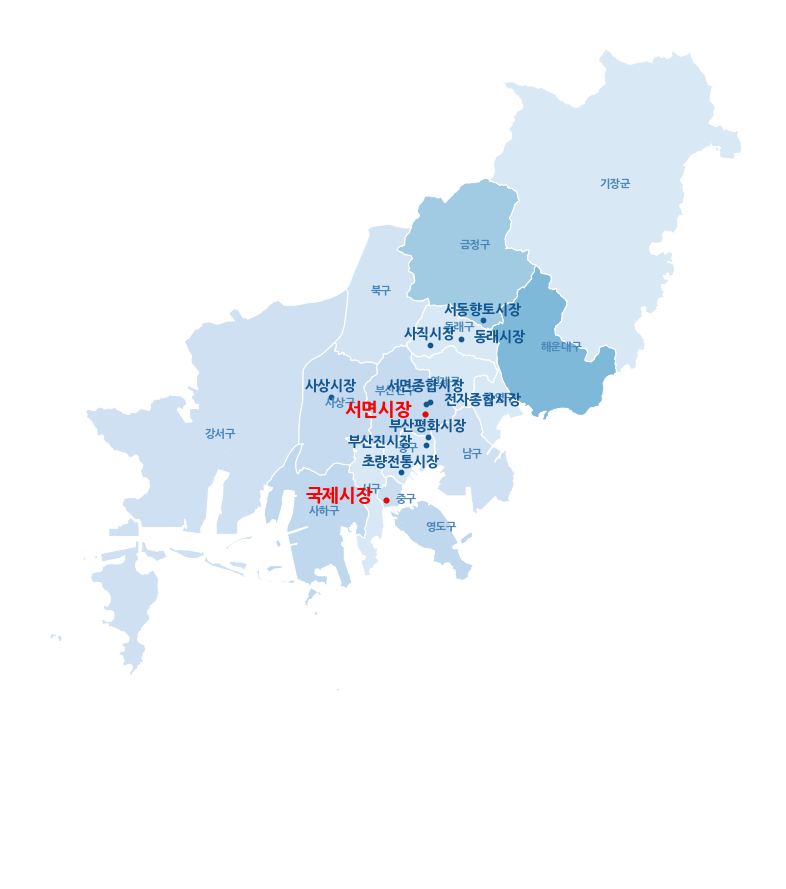

In [58]:
# 최종 부산 전통시장 플랏
from adjustText import adjust_text

# Plotting the map (keep this as it is)
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
gdf.plot(column='평일_여가생활_odcnts', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='white')

# x축, y축 및 눈금 제거
ax.set_axis_off()

# Add scatter points for 청년몰 (all markets in green except 서면시장 and 국제시장)
ax.scatter(부산청년몰위치['Longitude'], 부산청년몰위치['Latitude'], color='#135691', s=10, label='청년몰')

# 서면시장과 국제시장은 빨간색 점
ax.scatter(부산청년몰위치.loc[부산청년몰위치['시장명'].isin(['서면시장', '국제시장']), 'Longitude'],
           부산청년몰위치.loc[부산청년몰위치['시장명'].isin(['서면시장', '국제시장']), 'Latitude'], 
           color='red', s=10)

# Store texts to be adjusted (removed arrows adjustment)
texts_no_arrows = []  # For 시장명 without arrows

# Add 시군구 labels dynamically (without arrows)
for idx, row in gdf.iterrows():
    text = ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['SIG_KOR_NM'], 
                   fontsize=8, ha='center', color='#4c87ba', weight='bold')
    texts_no_arrows.append(text)

# Add the labels for 청년몰 and market names with specific rules
for i, row in 부산청년몰위치.iterrows():
    if row['시장명'] in ['서면시장', '국제시장']:
        # 서면시장 and 국제시장은 빨간색으로 점 왼쪽에 텍스트
        ax.text(row['Longitude'] - 0.01, row['Latitude'], row['시장명'], 
                fontsize=13, ha='right', color='red', weight='bold')
    elif row['시장명'] == '동래시장':
        # 동래시장은 초록색으로 점 오른쪽에 텍스트
        ax.text(row['Longitude'] + 0.01, row['Latitude'], row['시장명'], 
                fontsize=10, ha='left', color='#135691', weight='bold')
    elif row['시장명'] == '부산진시장':
        # 부산진시장은 초록색으로 점 왼쪽에 텍스트
        ax.text(row['Longitude'] - 0.01, row['Latitude'], row['시장명'], 
                fontsize=10, ha='right', color='#135691', weight='bold')
    elif row['시장명'] == '전자종합시장':
        # 전자종합시장은 초록색으로 점 오른쪽에 텍스트
        ax.text(row['Longitude'] + 0.01, row['Latitude'], row['시장명'], 
                fontsize=10, ha='left', color='#135691', weight='bold')
    elif row['시장명'] == '서면종합시장':
        # 서면종합시장은 텍스트를 점 위쪽으로 이동
        ax.text(row['Longitude'], row['Latitude'] + 0.01, row['시장명'], 
                fontsize=10, ha='center', color='#135691', weight='bold')
    else:
        # 나머지 시장들은 초록색으로 텍스트 (진초록색)
        ax.text(row['Longitude'], row['Latitude'] + 0.005, row['시장명'], 
                fontsize=10, ha='center', color='#135691', weight='bold')

# Adjust the 시군구 text positions without arrows
adjust_text(texts_no_arrows, only_move={'points': 'y', 'texts': 'y'}, autoalign='y', ax=ax)

# Final plot display
plt.tight_layout()
plt.show()


#### (시군구) 부산 유입인구 합 비율

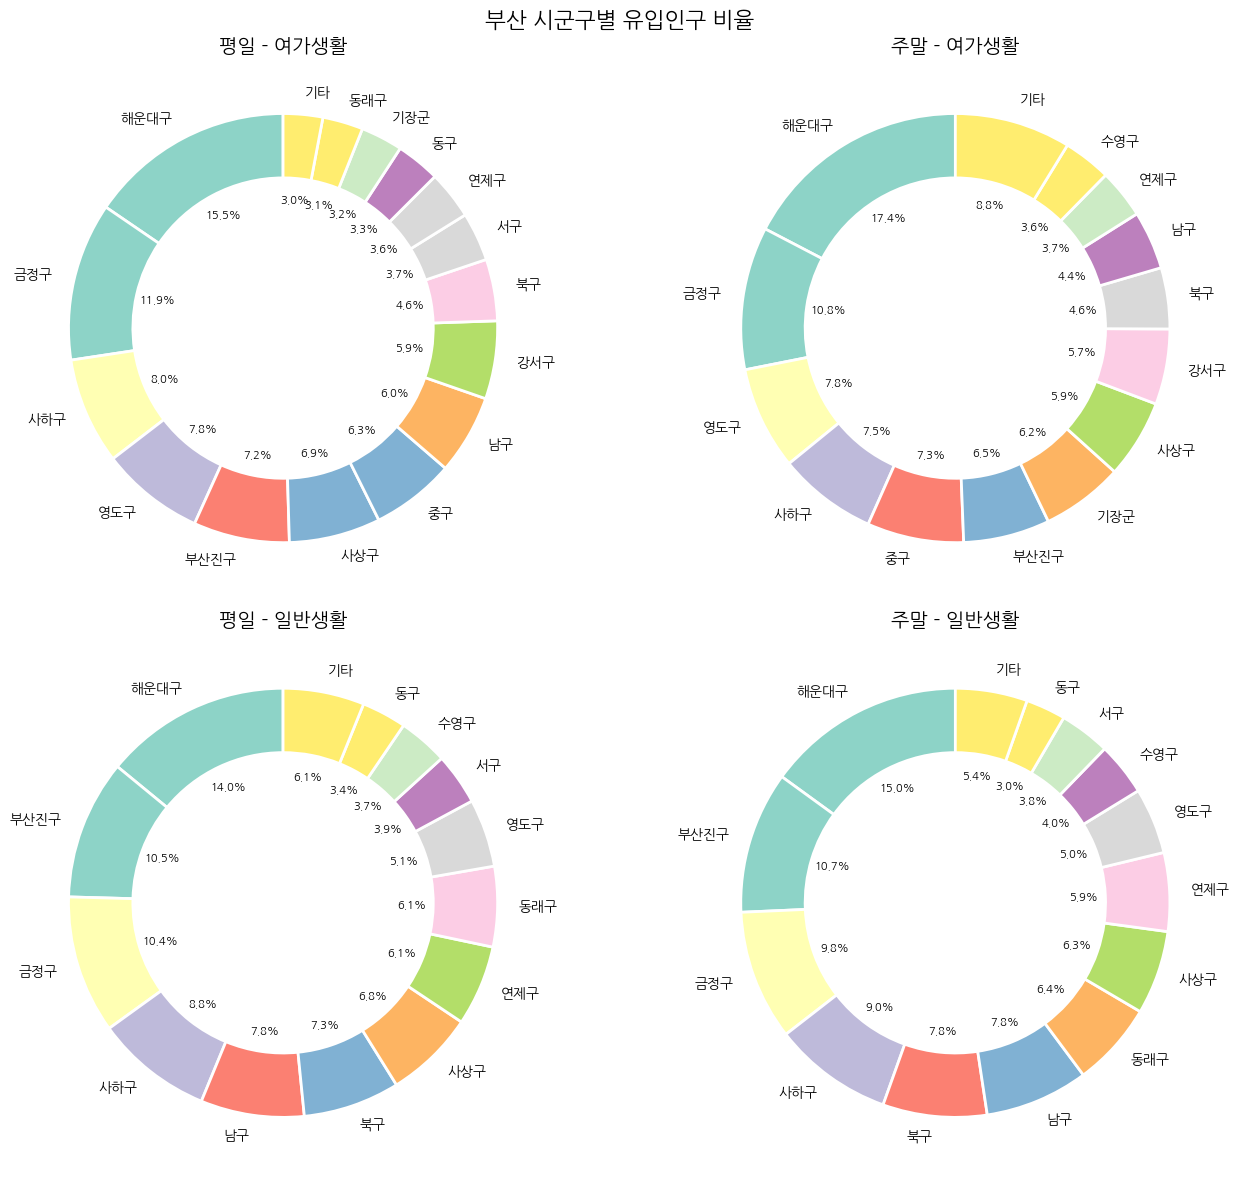

In [18]:
plt.rcParams['font.family'] = 'NanumGothic'

grouped_data_평일 = weekday_data.groupby(["유입목적", "dest_hdong_cd_시군구명"])[['od_cnts']].sum().sort_values(by=["유입목적", "od_cnts"], ascending=[True, False])
grouped_data_주말 = weekend_data.groupby(["유입목적", "dest_hdong_cd_시군구명"])[['od_cnts']].sum().sort_values(by=["유입목적", "od_cnts"], ascending=[True, False])

# 기타로 묶는 함수 정의
def combine_small_categories(purpose_data, threshold=0.03):
    total = purpose_data['od_cnts'].sum()
    purpose_data['percentage'] = purpose_data['od_cnts'] / total
    large_categories = purpose_data[purpose_data['percentage'] >= threshold]
    small_categories = purpose_data[purpose_data['percentage'] < threshold]
    
    if len(small_categories) > 0:
        # 기타 항목 추가
        other_sum = small_categories['od_cnts'].sum()
        other_row = pd.DataFrame({'od_cnts': [other_sum]}, index=['기타'])
        large_categories = pd.concat([large_categories, other_row])
    
    # percentage 열 삭제
    large_categories = large_categories.drop(columns='percentage')
    return large_categories


# 유입목적별 데이터를 도넛형 차트로 그리는 함수
def plot_donut_chart_for_purpose(purpose_data, purpose_title, ax):
    purpose_data = combine_small_categories(purpose_data)  # 기타로 묶음
    colors = plt.cm.get_cmap('Set3', len(purpose_data))  # 다양한 색상 설정
    #colors = plt.cm.get_cmap('Pastel1', len(purpose_data))
    
    wedges, texts, autotexts = ax.pie(
        purpose_data['od_cnts'], 
        labels=purpose_data.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=[colors(i) for i in range(len(purpose_data))],  # 고유한 색상
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2)  # 두꺼운 선 추가
    )
    
    # 차트 가운데에 텍스트 추가
    ax.set_title(purpose_title, fontsize=14)
    
    # 텍스트와 숫자의 크기 조정
    for text in texts:
        text.set_fontsize(10)  # 라벨의 폰트 크기
    for autotext in autotexts:
        autotext.set_fontsize(8)  # 숫자의 폰트 크기를 더 작게 설정

# 그래프 그리기 위한 플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2행 2열의 서브플롯
plt.suptitle('부산 시군구별 유입인구 비율', fontsize=16)

# 여가생활 데이터 필터링 및 시각화
leisure_data_평일 = grouped_data_평일.loc['여가생활']
plot_donut_chart_for_purpose(leisure_data_평일, '평일 - 여가생활', axes[0, 0])
leisure_data_주말 = grouped_data_주말.loc['여가생활']
plot_donut_chart_for_purpose(leisure_data_주말, '주말 - 여가생활', axes[0, 1])

# 일반생활 데이터 필터링 및 시각화
general_life_data_평일 = grouped_data_평일.loc['일반생활']
plot_donut_chart_for_purpose(general_life_data_평일, '평일 - 일반생활', axes[1, 0])
general_life_data_주말 = grouped_data_주말.loc['일반생활']
plot_donut_chart_for_purpose(general_life_data_주말, '주말 - 일반생활', axes[1, 1])

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

